In [73]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [74]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Data Source 
https://datenplattform.darmstadt.de/verkehr/apps/opendata/#/\

## Importing The Data

###   *************************************Data Preparation******************************************

In [75]:
%store -r dfarima

In [76]:
dflstm= dfarima 
dflstm.head()

,Sum
Time,
2022-01-01,19996
2022-01-02,37186
2022-01-03,28235
2022-01-04,34317
2022-01-06,36647


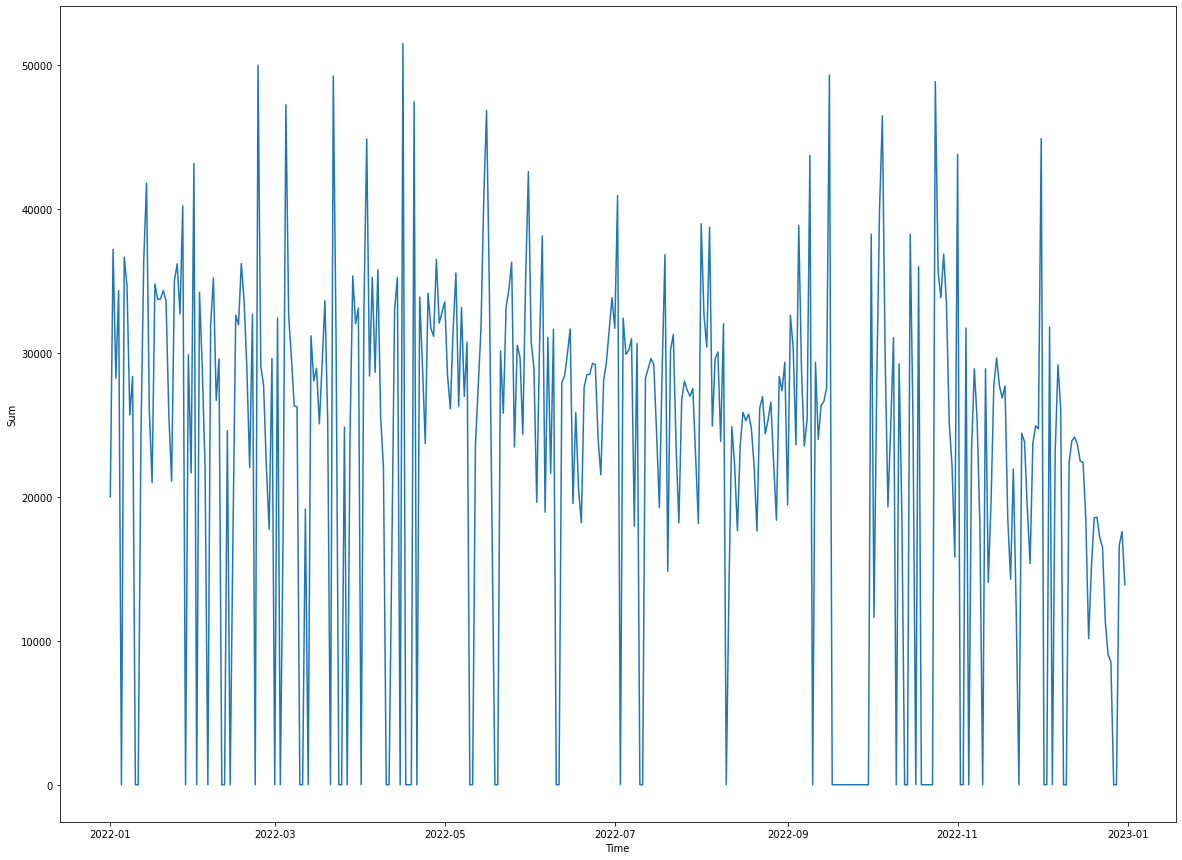

In [77]:

fig, ax = plt.subplots(figsize=(20, 15))
sns.lineplot(x=df.index, y="Sum", data=df);

plt.show()

In [78]:


# calculate the IQR for each column in the DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# define the lower and upper bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# create a boolean mask for the outlier rows in the DataFrame
outlier_mask = ~df.apply(lambda x: ((x < lower_bound) | (x > upper_bound)).any(), axis=1)

# select the rows without outliers
df_clean = df[outlier_mask]
df_clean.size
df_clean.describe()

,Sum
count,362.000000
mean,22514.850829
std,13235.943799
min,0.000000
25%,17180.250000
50%,25825.000000
75%,31247.000000
max,51487.000000


In [79]:
df= df_clean

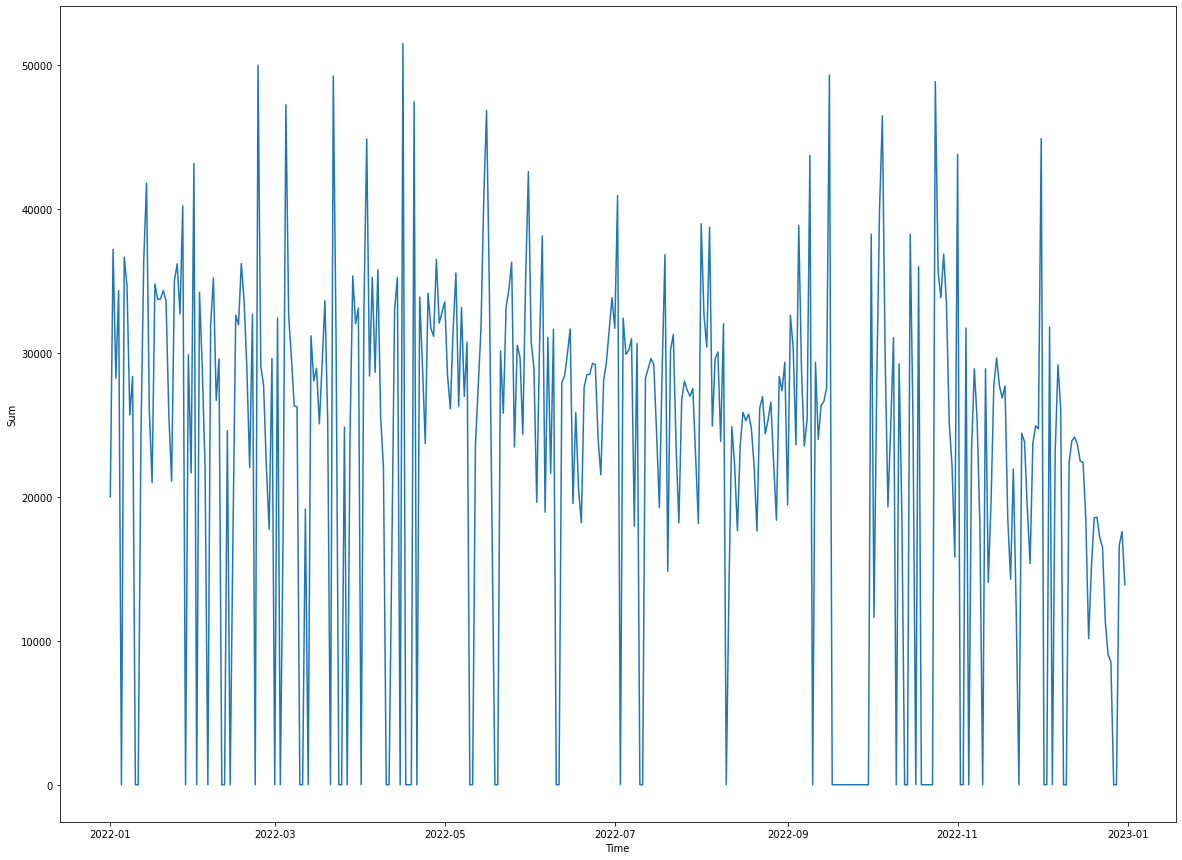

In [80]:

fig, ax = plt.subplots(figsize=(20, 15))
sns.lineplot(x=df.index, y="Sum", data=df);

plt.show()

Now our Data is ready to be analysis and modify

In [81]:
df.drop(df.columns.difference(['Time','Sum']), 1, inplace=True)

df.head()

C:\Users\engin\AppData\Local\Temp\ipykernel_9520\2181991119.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['Time','Sum']), 1, inplace=True)


,Sum
Time,
2022-01-01,19996
2022-01-02,37186
2022-01-03,28235
2022-01-04,34317
2022-01-05,0


In [82]:
df.describe()

,Sum
count,362.000000
mean,22514.850829
std,13235.943799
min,0.000000
25%,17180.250000
50%,25825.000000
75%,31247.000000
max,51487.000000


In [83]:
df = df.resample('H').sum()
df = df.resample('D').sum()
df.head()

,Sum
Time,
2022-01-01,19996
2022-01-02,37186
2022-01-03,28235
2022-01-04,34317
2022-01-05,0


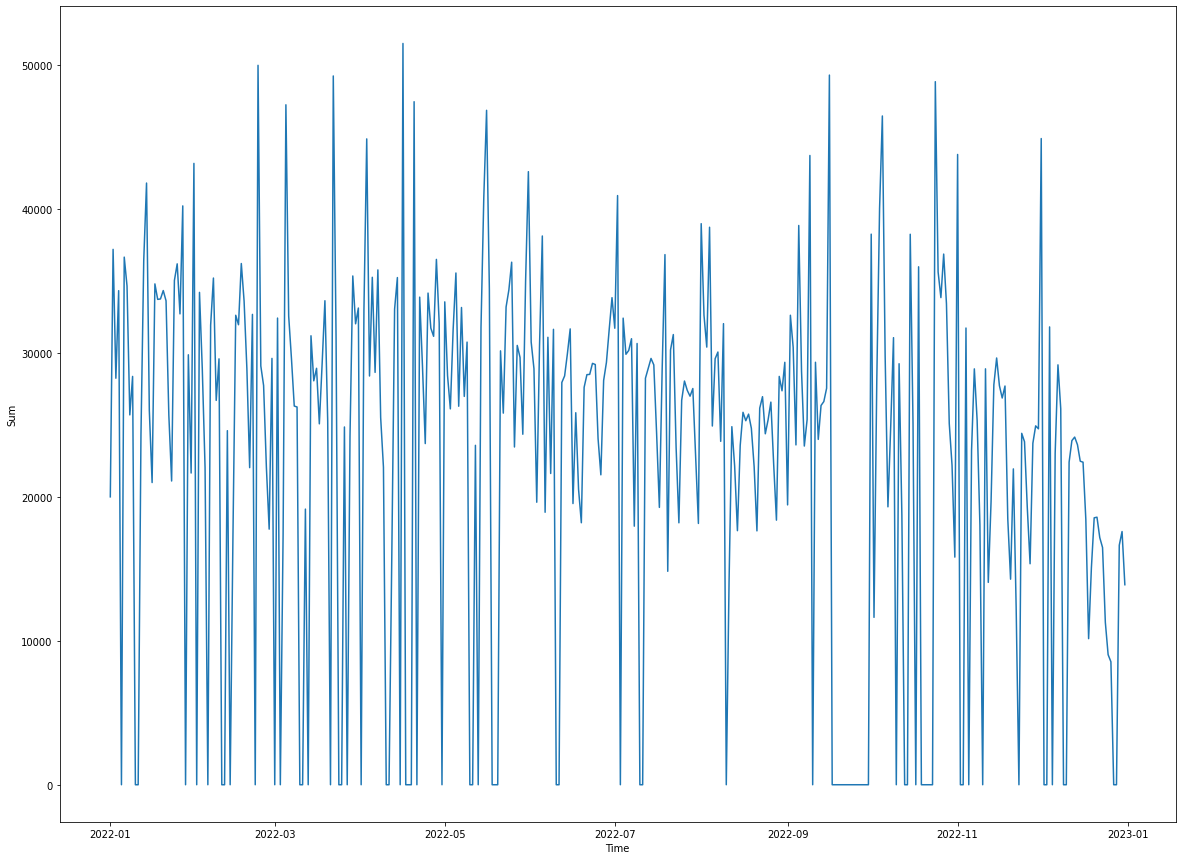

In [84]:

fig, ax = plt.subplots(figsize=(20, 15))
sns.lineplot(x=df.index, y="Sum", data=df);

plt.show()

##  ________________________________________________ |Outlier|________________________________________________
When exploring data, the outliers are the extreme values within the dataset.
 That means the outlier data points vary greatly from the expected values—either being much larger or 
 significantly smaller. 

In [85]:


# calculate the IQR for each column in the DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# define the lower and upper bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# create a boolean mask for the outlier rows in the DataFrame
outlier_mask = ~df.apply(lambda x: ((x < lower_bound) | (x > upper_bound)).any(), axis=1)

# select the rows without outliers
df_clean = df[outlier_mask]
df_clean.size
df_clean.describe()

,Sum
count,365.000000
mean,22329.797260
std,13337.537021
min,0.000000
25%,16476.000000
50%,25742.000000
75%,31184.000000
max,51487.000000


In [86]:
df= df_clean

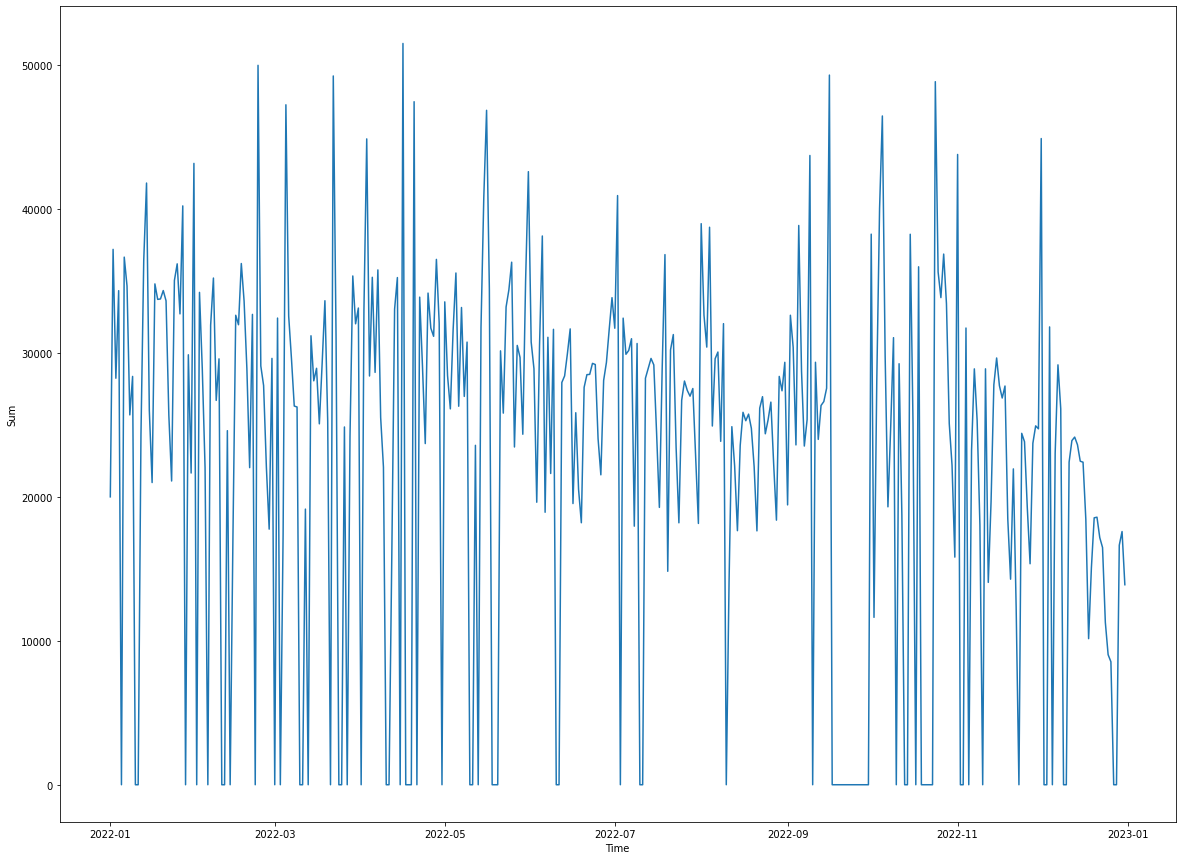

In [87]:

fig, ax = plt.subplots(figsize=(20, 15))
sns.lineplot(x=df.index, y="Sum", data=df);

plt.show()

sns.lineplot(x=df.index, y="Sum", data=df);

##  ___________________________________ |Feature Engineering|________________________________________________

 https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0

In [88]:
dflstm.head()

,Sum
Time,
2022-01-01,19996
2022-01-02,37186
2022-01-03,28235
2022-01-04,34317
2022-01-06,36647


In [89]:

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday
from datetime import date

class DarmstadtHolidayCalendar(AbstractHolidayCalendar):
    """
    Custom holiday calendar for Darmstadt.
    """
    rules = [
        Holiday('Neujahrstag', month=1, day=1),
        Holiday('Karfreitag', month=4, day=15),
        Holiday('Ostermontag', month=4, day=18),
        Holiday('Tag der Arbeit', month=5, day=1),
        Holiday('Christi Himmelfahrt', month=5, day=26),
        Holiday('Pfingstmontag', month=6, day=6),
        Holiday('Fronleichnam', month=6, day=16),
        Holiday('Tag der deutschen Einheit', month=10, day=3),
        Holiday('Allerheiligen', month=11, day=1),
        Holiday('1. Weihnachtstag', month=12, day=25),
        Holiday('2. Weihnachtstag', month=12, day=26),
    ]

# Define the date range for which to generate Darmstadt holidays
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)

# Create the Darmstadt holiday calendar and generate the holidays
cal = DarmstadtHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)

print(holidays)


DatetimeIndex(['2022-01-01', '2022-04-15', '2022-04-18', '2022-05-01',
               '2022-05-26', '2022-06-06', '2022-06-16', '2022-10-03',
               '2022-11-01', '2022-12-25', '2022-12-26'],
              dtype='datetime64[ns]', freq=None)


In [90]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_weather_data(start_date, end_date, api_key):
    # Define the API endpoint and query parameters
    url = 'https://api.openweathermap.org/data/2.5/onecall'
    params = {
        'q': 'Darmstadt',
        'exclude': 'current,minutely,alerts',
        'units': 'metric',
        'appid': api_key
    }
    
    # Initialize an empty list to store the weather data
    weather_data = []
    
    # Loop through each day between the start and end dates
    current_date = datetime.strptime(start_date, '%d.%m.%Y')
    end_date = datetime.strptime(end_date, '%d.%m.%Y')
    while current_date < end_date:
        # Add the current date to the query parameters
        params['dt'] = int(current_date.timestamp())
        
        # Send a GET request to the API endpoint with the query parameters
        response = requests.get(url, params=params)
        data = response.json()
        
        # Check if it rained on the current date
        rain = 0
        if 'hourly' in data:
            for item in data['hourly']:
                if 'rain' in item and '1h' in item['rain']:
                    rain += item['rain']['1h']
        if rain > 0:
            weather_data.append([current_date.date(), 'Raining'])
        else:
            weather_data.append([current_date.date(), 'Not Raining'])
        
        # Move on to the next day
        current_date += timedelta(days=1)
    
    # Create a pandas dataframe from the weather data
    df = pd.DataFrame(weather_data, columns=['Date', 'Rain'])
    df.set_index('Date', inplace=True)
    
    return df
dfrain = get_weather_data("01.01.2022","01.01.2023","0347acab69dbc131865c25997c191acd" )

In [91]:
# select the column you want to add from the original DataFrame
column_to_add = dfrain['Rain']

# add the selected column to the new DataFrame
df2 = dflstm.assign(B=column_to_add)



0347acab69dbc131865c25997c191acd

In [92]:
df2.head()

,Sum,B
Time,,
2022-01-01,19996,Not Raining
2022-01-02,37186,Not Raining
2022-01-03,28235,Not Raining
2022-01-04,34317,Not Raining
2022-01-06,36647,Not Raining


In [93]:
def create_features(df, holidays):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # df['hours']= df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    # Add a new feature to indicate whether the date is a holiday or not
    df['is_holiday'] = df.index.isin(holidays).astype(int)
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['year'] = df.index.year
    df['Sum']= df['Sum']
    

    

    
    return df

# Define the date range for which to generate Darmstadt holidays
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)

# Create the Darmstadt holiday calendar and generate the holidays
cal = DarmstadtHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)

# Call the create_features function and pass the holidays list as an argument
df = create_features(df, holidays)
df.tail()


,Sum,dayofweek,month,dayofmonth,is_holiday,is_weekend,quarter,dayofyear,weekofyear,year
Time,,,,,,,,,,
2022-12-27,0,1,12,27,0,0,4,361,52,2022
2022-12-28,0,2,12,28,0,0,4,362,52,2022
2022-12-29,16638,3,12,29,0,0,4,363,52,2022
2022-12-30,17586,4,12,30,0,0,4,364,52,2022
2022-12-31,13892,5,12,31,0,1,4,365,52,2022


In [94]:
df.tail()

,Sum,dayofweek,month,dayofmonth,is_holiday,is_weekend,quarter,dayofyear,weekofyear,year
Time,,,,,,,,,,
2022-12-27,0,1,12,27,0,0,4,361,52,2022
2022-12-28,0,2,12,28,0,0,4,362,52,2022
2022-12-29,16638,3,12,29,0,0,4,363,52,2022
2022-12-30,17586,4,12,30,0,0,4,364,52,2022
2022-12-31,13892,5,12,31,0,1,4,365,52,2022


In [95]:
## 1-  Loading the Data of A51 
df = pd.read_csv("A51.csv", delimiter=";")
df.head()

,Datum,Uhrzeit,Bezeichnung,Intervall,D21Z,D21B,D22Z,D22B,D23Z,D23B,...,TB38Z,TB38B,TB39Z,TB39B,TB41Z,TB41B,ST58Z,ST58B,ST59Z,ST59B
0,01.01.2023,10:11,A 51,1,0,0,2,86,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01.01.2023,10:10,A 51,1,0,0,1,13,0,0,...,0,0,0,0,0,0,0,0,0,0
2,01.01.2023,10:09,A 51,1,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,01.01.2023,10:08,A 51,1,0,0,1,19,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01.01.2023,10:07,A 51,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
df = df.drop(columns=["Intervall","Bezeichnung"])
# Create a boolean mask
mask = [not col.endswith('B') for col in df.columns] #according to the source of the Data the Columns that end with B is Time share with sensor deflection so it will be deleted  
# Use the mask to filter the DataFrame
df = df.filter(items=df.columns[mask])
df.head()

,Datum,Uhrzeit,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,...,TF39Z,TF41Z,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z
0,01.01.2023,10:11,0,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,01.01.2023,10:10,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,01.01.2023,10:09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,01.01.2023,10:08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01.01.2023,10:07,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:

df['Time'] = df[['Datum', 'Uhrzeit']].apply(lambda x: ' '.join(x), axis=1)
df['Time'] = pd.to_datetime(df['Time'])
df.head()

,Datum,Uhrzeit,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,...,TF41Z,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z,Time
0,01.01.2023,10:11,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2023-01-01 10:11:00
1,01.01.2023,10:10,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2023-01-01 10:10:00
2,01.01.2023,10:09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-01 10:09:00
3,01.01.2023,10:08,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-01 10:08:00
4,01.01.2023,10:07,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2023-01-01 10:07:00


In [98]:
df['Sum'] = df.iloc[:, 1:].sum(axis=1)
df.tail()

C:\Users\engin\AppData\Local\Temp\ipykernel_9520\3429654073.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Sum'] = df.iloc[:, 1:].sum(axis=1)


,Datum,Uhrzeit,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,...,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z,Time,Sum
500907,01.01.2022,09:16,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:16:00,4
500908,01.01.2022,09:15,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,2022-01-01 09:15:00,5
500909,01.01.2022,09:14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:14:00,0
500910,01.01.2022,09:13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:13:00,3
500911,01.01.2022,09:12,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-01 09:12:00,2


In [99]:
df = df.drop(columns=["Datum","Uhrzeit"])


df.set_index('Time', inplace=True)
df.tail()

,D21Z,D22Z,D23Z,V24Z,V25Z,V26Z,D81Z,V82Z,D91Z,V92Z,...,TF41Z,TB32Z,TB35Z,TB37Z,TB38Z,TB39Z,TB41Z,ST58Z,ST59Z,Sum
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 09:16:00,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2022-01-01 09:15:00,0,0,0,0,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,5
2022-01-01 09:14:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-01 09:13:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2022-01-01 09:12:00,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [100]:
df.drop(df.columns.difference(['Time','Sum']), 1, inplace=True)

df.head()

C:\Users\engin\AppData\Local\Temp\ipykernel_9520\2181991119.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['Time','Sum']), 1, inplace=True)


,Sum
Time,
2023-01-01 10:11:00,7
2023-01-01 10:10:00,4
2023-01-01 10:09:00,0
2023-01-01 10:08:00,1
2023-01-01 10:07:00,2


In [101]:
df.describe()

,Sum
count,500912.000000
mean,27.908621
std,40.155569
min,0.000000
25%,8.000000
50%,20.000000
75%,31.000000
max,545.000000


In [102]:
df = df.resample('H').sum()
df = df.resample('D').sum()
df.head()

,Sum
Time,
2022-01-01,19996
2022-01-02,37186
2022-01-03,28235
2022-01-04,34317
2022-01-05,113428


## Adding Features that play the a Roles in The Number of cars going into The intersecation 

Data Visualiseriung 

In [103]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10


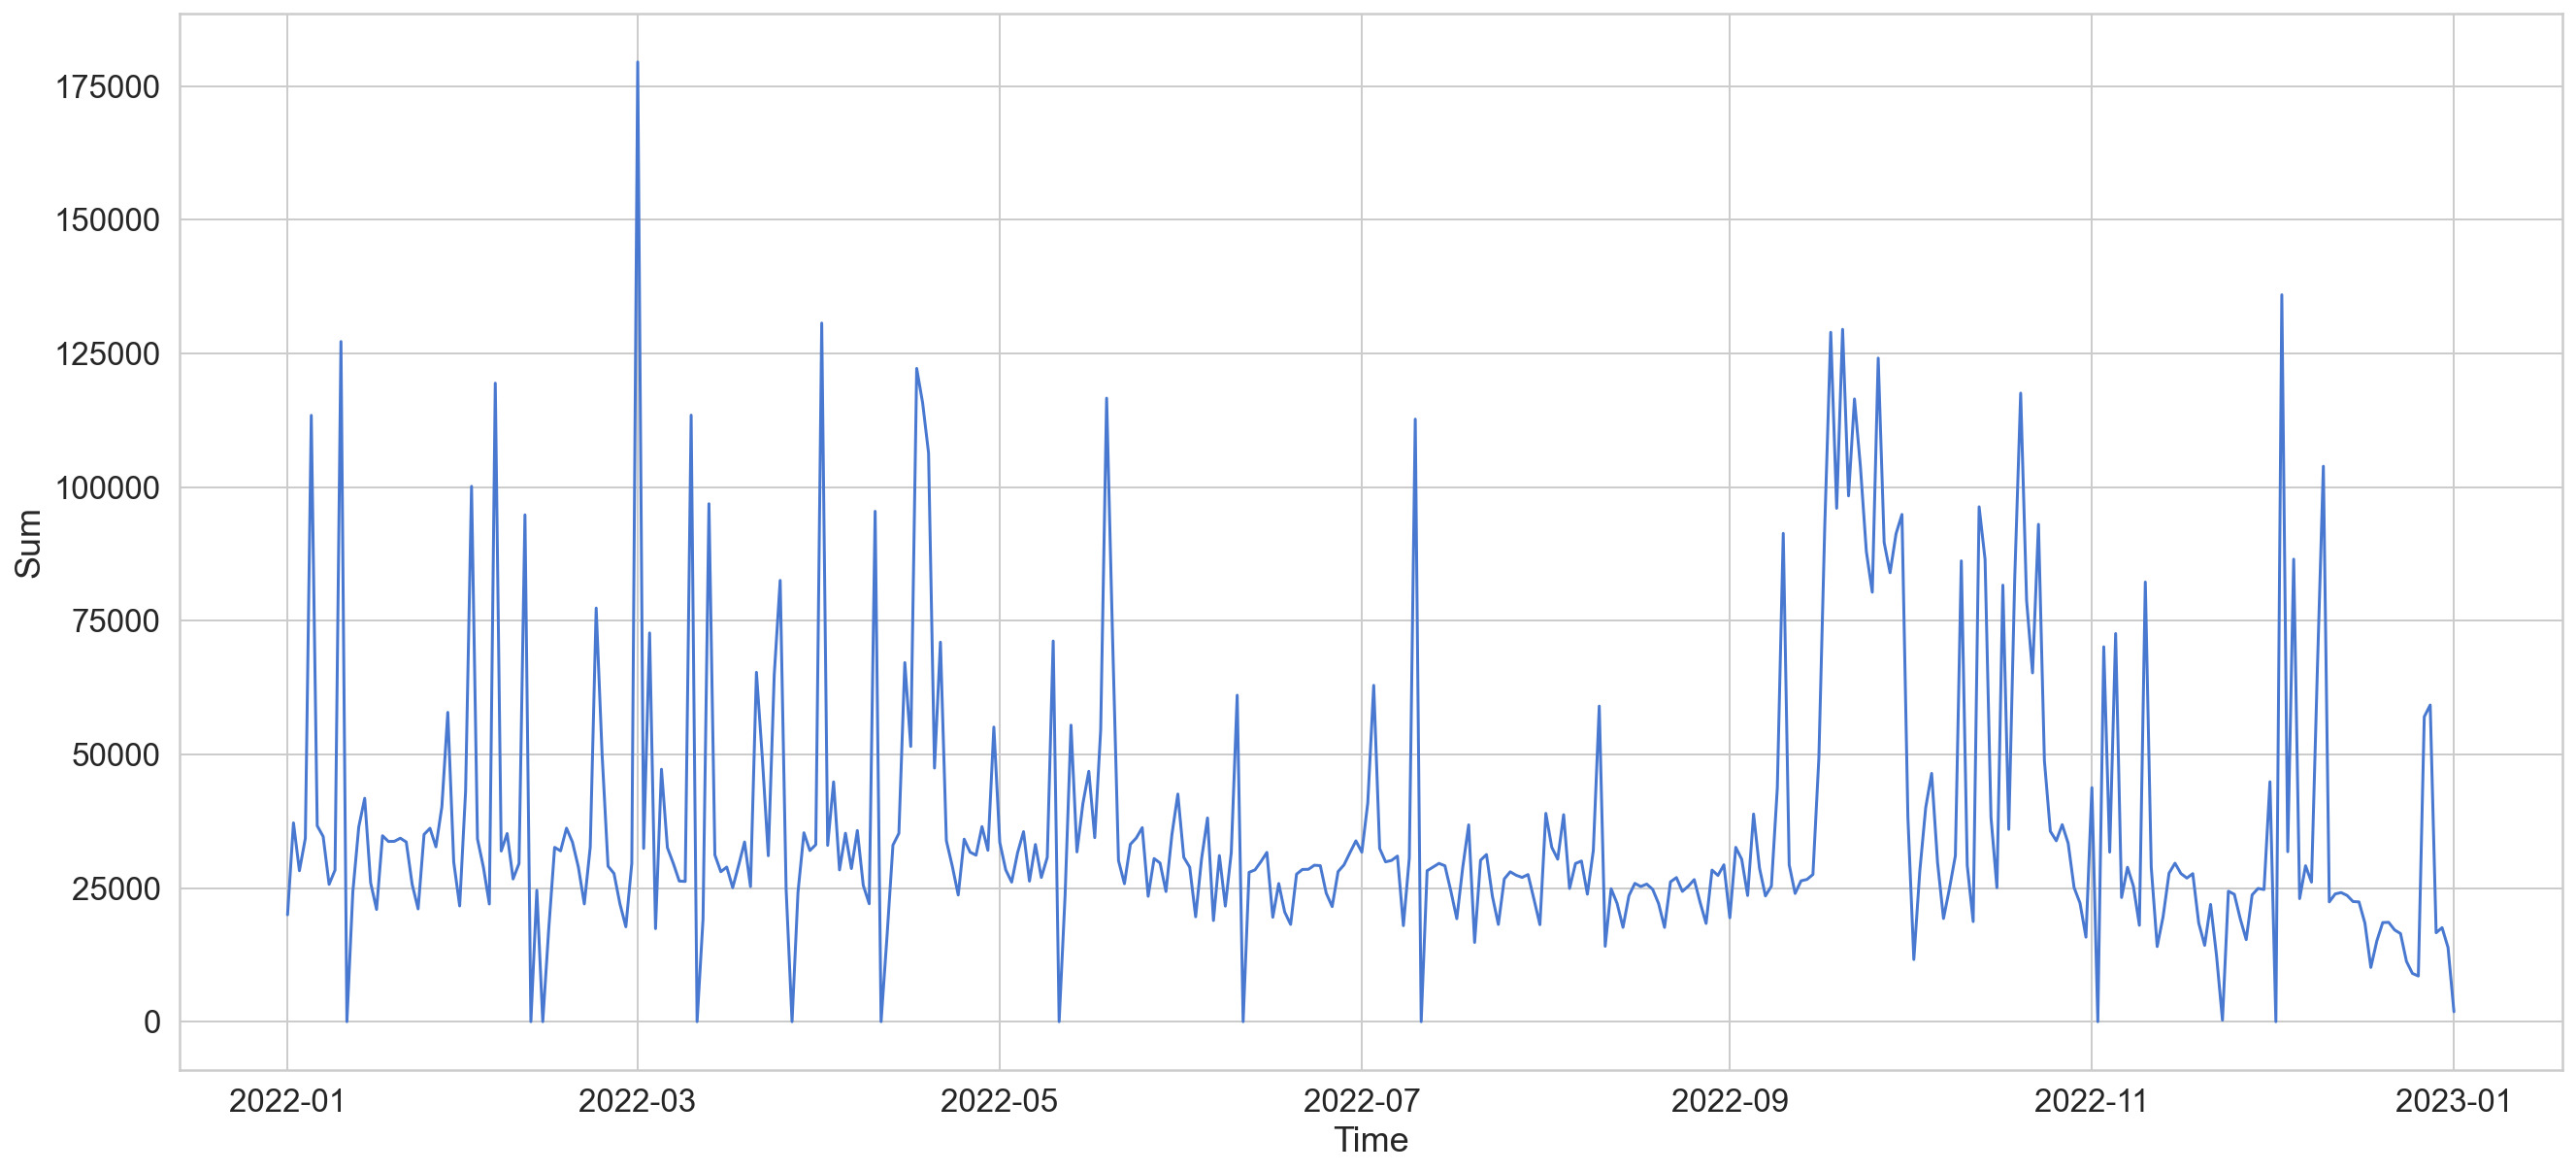

In [104]:
sns.lineplot(x=df.index, y="Sum", data=df);

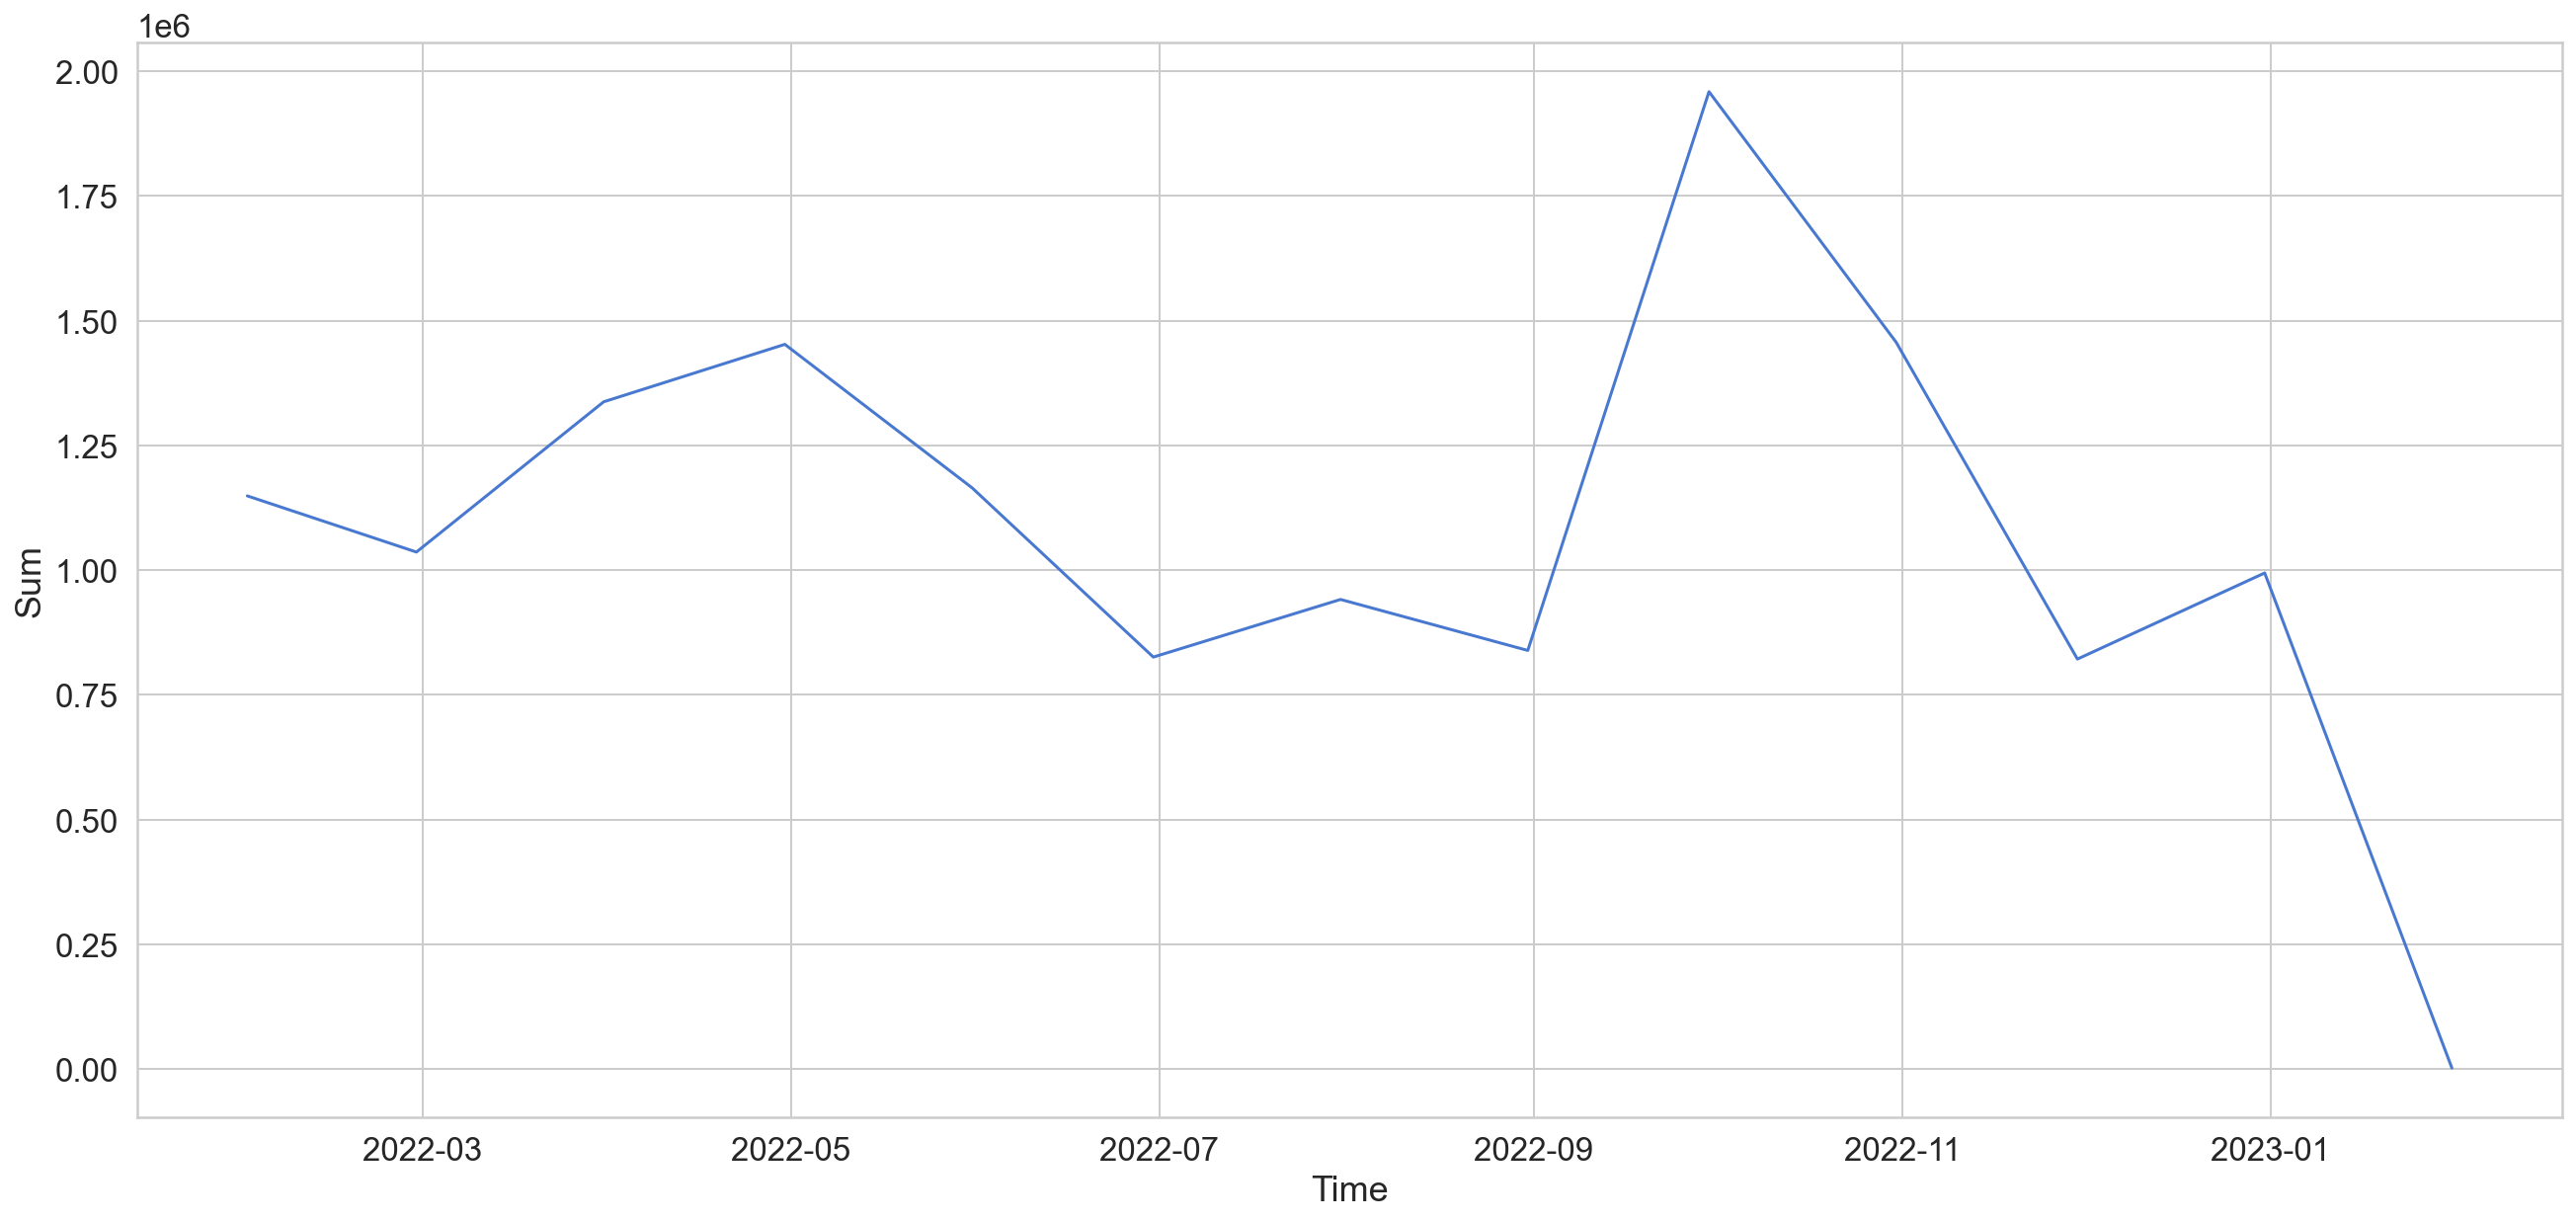

In [105]:
# shpowing the Sum by Months
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="Sum", data=df_by_month);

ValueError: Could not interpret input 'dayofweek'

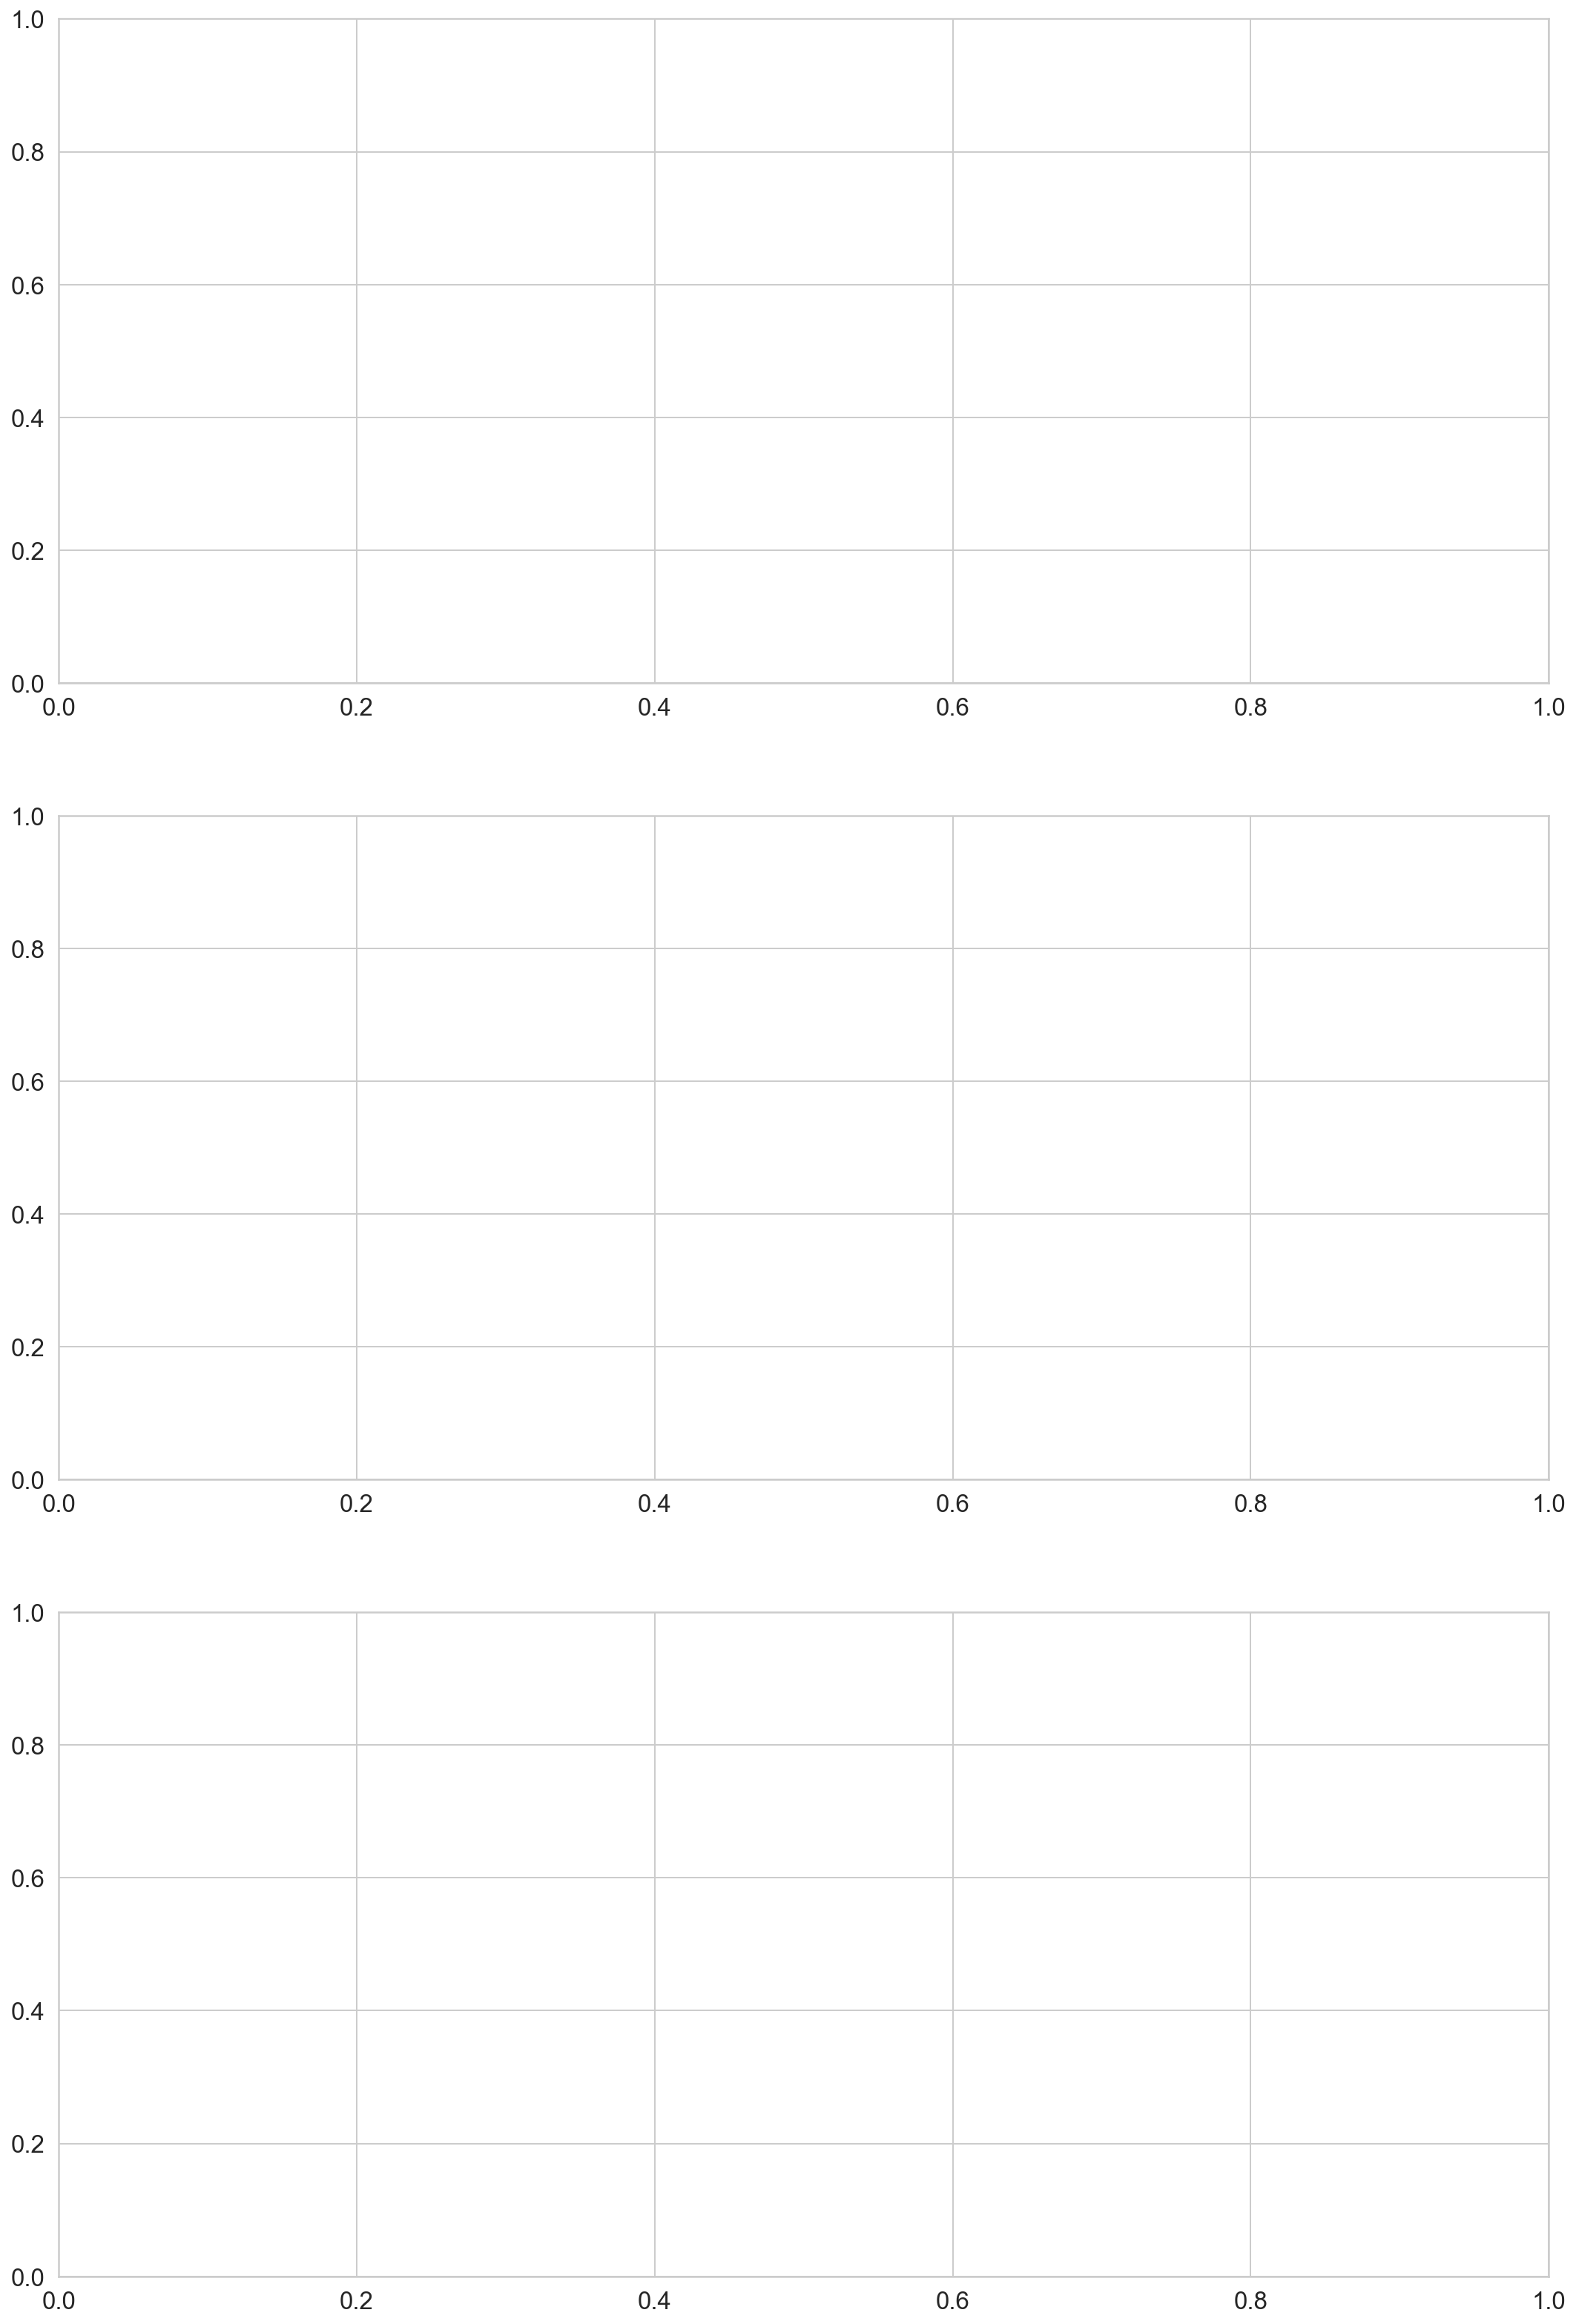

In [106]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='dayofweek', y='Sum', ax=ax1)
sns.pointplot(data=df, x='dayofweek', y='Sum', hue='holiday', ax=ax2)
sns.pointplot(data=df, x='dayofweek', y='Sum', hue='is_weekend', ax=ax3)


In [ ]:
plt.plot(df.index, df['Sum'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sum')
plt.title('Total Sum Over Time')

In [ ]:
df = df.reset_index(drop=False)


In [ ]:
train_dates = pd.to_datetime(df['Time'])
print(train_dates.tail(7)) 

In [ ]:
cols = list(df)[1:7]
#Date and  columns are not used in training. 
print(cols) 

#New dataframe with only training data - 6 columns


In [ ]:
df_for_training = df[cols].astype(float)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7 

In [ ]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

In [ ]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:

# fit the model
history = model.fit(trainX, trainY, epochs=7, batch_size=14, validation_split=0.1, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday
from datetime import date

class DarmstadtHolidayCalendar(AbstractHolidayCalendar):
    """
    Custom holiday calendar for Darmstadt.
    """
    rules = [
        Holiday('Neujahrstag', month=1, day=1),
        Holiday('Karfreitag', month=4, day=15),
        Holiday('Ostermontag', month=4, day=18),
        Holiday('Tag der Arbeit', month=5, day=1),
        Holiday('Christi Himmelfahrt', month=5, day=26),
        Holiday('Pfingstmontag', month=6, day=6),
        Holiday('Fronleichnam', month=6, day=16),
        Holiday('Tag der deutschen Einheit', month=10, day=3),
        Holiday('Allerheiligen', month=11, day=1),
        Holiday('1. Weihnachtstag', month=12, day=25),
        Holiday('2. Weihnachtstag', month=12, day=26),
    ]

# Define the date range for which to generate Darmstadt holidays
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)

# Create the Darmstadt holiday calendar and generate the holidays
cal = DarmstadtHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)

print(holidays)


In [ ]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
# from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=DarmstadtHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

In [ ]:
df.head()

In [ ]:
df.head()

In [ ]:
train_dates = df['Time']

In [ ]:

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

Data Vis

Training 

In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])

In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())


In [ ]:

df_forecast = pd.DataFrame({'Time':np.array(forecast_dates), 'Sum':y_pred_future})
df_forecast['Time']=pd.to_datetime(df_forecast['Time'])



In [ ]:

df_forecast.head()

In [ ]:

original = df[['Time', 'Sum']]
original['Time']=pd.to_datetime(original['Time'])
original = original.loc[original['Time'] >= '2022-12-14']



In [ ]:
original.head()


In [ ]:
# create a line plot of the forecasted data
sns.lineplot(x='Time', y='Sum', data=df_forecast)

# set the title and axis labels
plt.title('Forecasted Sum')
plt.xlabel('Time')
plt.ylabel('Sum')

fig = plt.figure(figsize=(50,15))

# display the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a line plot of the forecasted data
sns.lineplot(x='Time', y='Sum', data=df_forecast)

# set the title and axis labels
plt.title('Forecasted Sum')
plt.xlabel('Time')
plt.ylabel('Sum')

# create a new figure with a larger size
fig = plt.figure(figsize=(10, 6))

# display the plot
plt.show()


In [ ]:
#Variables for training

cols = list(df)[1:9]

print(cols) 

In [ ]:
df_for_training = df[cols]

In [ ]:
df_for_training.head()

In [ ]:

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.


In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [ ]:

#capture the Trianing and Test 
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [ ]:
# connvert them to array 
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

In [ ]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [ ]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
# from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=DarmstadtHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

In [ ]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())



In [ ]:
df_forecast = pd.DataFrame({'Time':np.array(forecast_dates), 'Sum':y_pred_future})
df_forecast['Time']=pd.to_datetime(df_forecast['Time'])

In [ ]:
df.tail()

In [ ]:
df_forecast

In [ ]:
df

In [ ]:
original = df[['Time', 'Sum']]
original['Time']=pd.to_datetime(original['Sum'])
original = original.loc[original['Time'] >= '2023-01-03']


In [ ]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

len(forecast_dates)
len(y_pred_future)
# df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Future Sum':y_pred_future})
# df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


In [ ]:
df.tail()